In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>


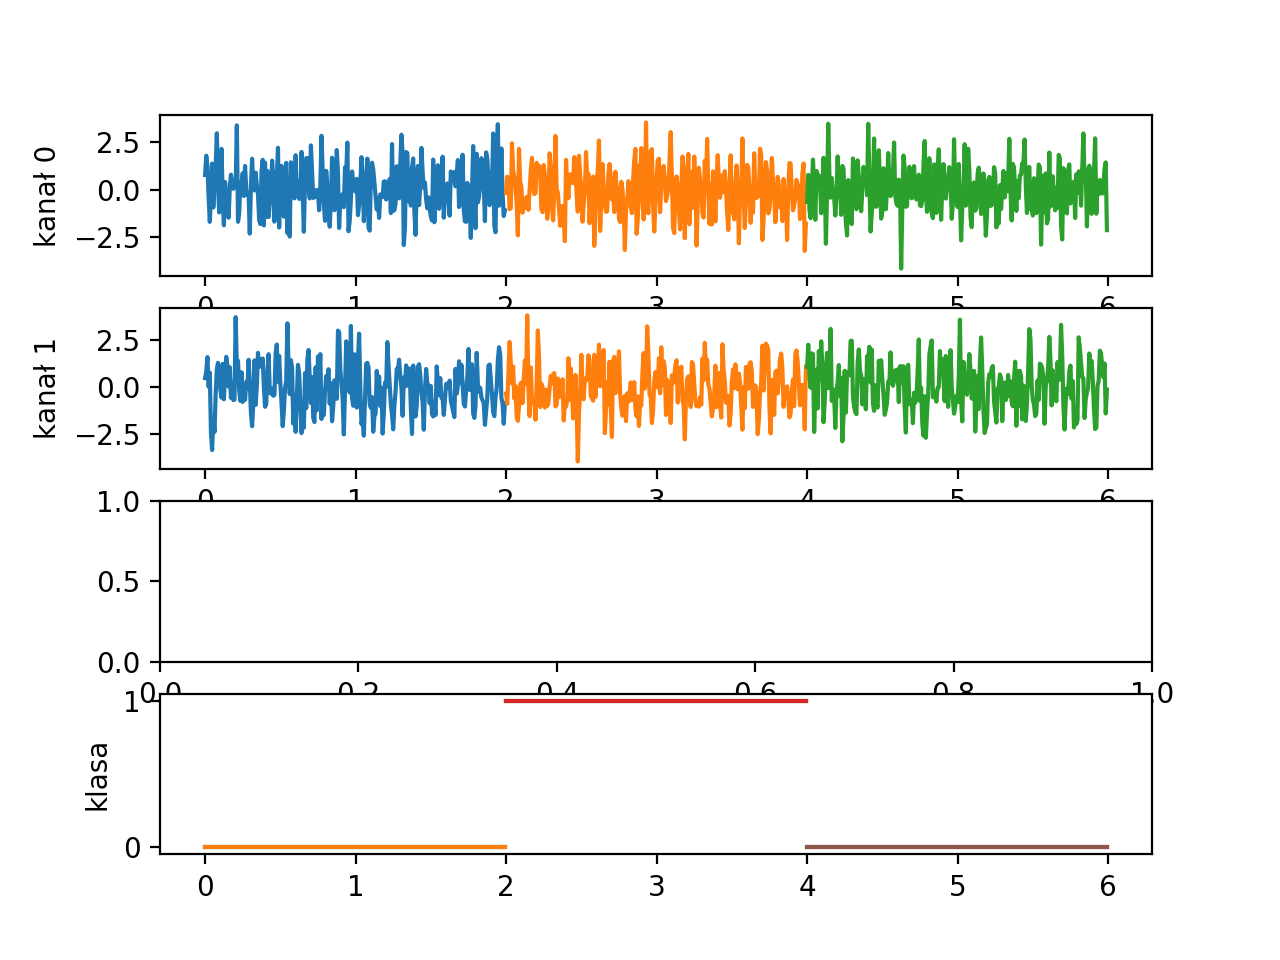

(800, 256, 2)
(800, 1)


In [18]:
Fs = 128 
T = 2
t = np.arange(0,T, 1/Fs)

nt = len(t) # liczba próbek w czasie jednego trialu
N = 400 # liczba przykładów na klasę
k = 2 #liczba klas
ch  = 2 # liczba kanałów


X  = np.random.randn(k*N,nt,ch )
Y = np.zeros((k*N,1))

przyklad =0
for tr in range(N):
    for klasa in range(k):
        Y[przyklad] = klasa
        if klasa ==0:
            X[przyklad, :, 0] += np.sin(2*np.pi*30*t)
            X[przyklad, :, 1] += np.sin(2*np.pi*15*t)
        if klasa==1:
            X[przyklad, :, 0] += np.sin(2*np.pi*25*t)
            X[przyklad, :, 1] += np.sin(2*np.pi*10*t)
        przyklad +=1


fig, ax = plt.subplots(4, 1)
for I_trial in range(3):
    for c in range(ch):
        ax[c].plot( I_trial*nt/Fs+t, X[I_trial,:,c] )
        ax[c].set_ylabel('kanał '+str(c))
        ax[3].plot(I_trial*nt/Fs+t,Y[I_trial]*np.ones(t.shape))
        ax[3].set_ylabel('klasa')

plt.show()
print(X.shape)
print(Y.shape)

In [19]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
y_train = to_categorical(y_train, num_classes=k)
y_test =  to_categorical(y_test, num_classes=k)

## Model z Conv1D

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

seq_length = nt
model = Sequential()
model.add(Conv1D(filters= 3, kernel_size = 30, input_shape=(seq_length, ch)))
model.add(GlobalAveragePooling1D())
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

model.fit(X_train, y_train, batch_size=16, epochs=100)
#score = model.evaluate(X_test, y_test, batch_size=16)
#print(score)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 227, 3)            183       
_________________________________________________________________
global_average_pooling1d_6 ( (None, 3)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 8         
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
600/600 [==============================] - 2s 3ms/step - loss: 0.6935 - acc: 0.4733
Epoch 2/100
600/600 [==============================] - 0s 359us/step - loss: 0.6921 - acc: 0.5467
Epoch 3/100
600/600 [==============================] - 1s 1ms/step - loss: 0.6906 - acc: 0.5767
Epoch 4/100
600/600 [==============================] - 0s 420us/step - loss: 0.6890 - acc: 0.5883
Epoch 5/100
600

Pobieramy wagi wszystkich filtrów

In [41]:
w= model.get_weights()

Filtry z zerowej warswy czy li naszego Conv1D mają kształt (dlugośc w czasie, kanały , liczba filtrów):

In [42]:
w[0].shape

(30, 2, 3)

Można je wykreślić jako przebieg czasowy - z takim kształtem splatany jest odpowiednio kanał 0 i 1 

<IPython.core.display.Javascript object>


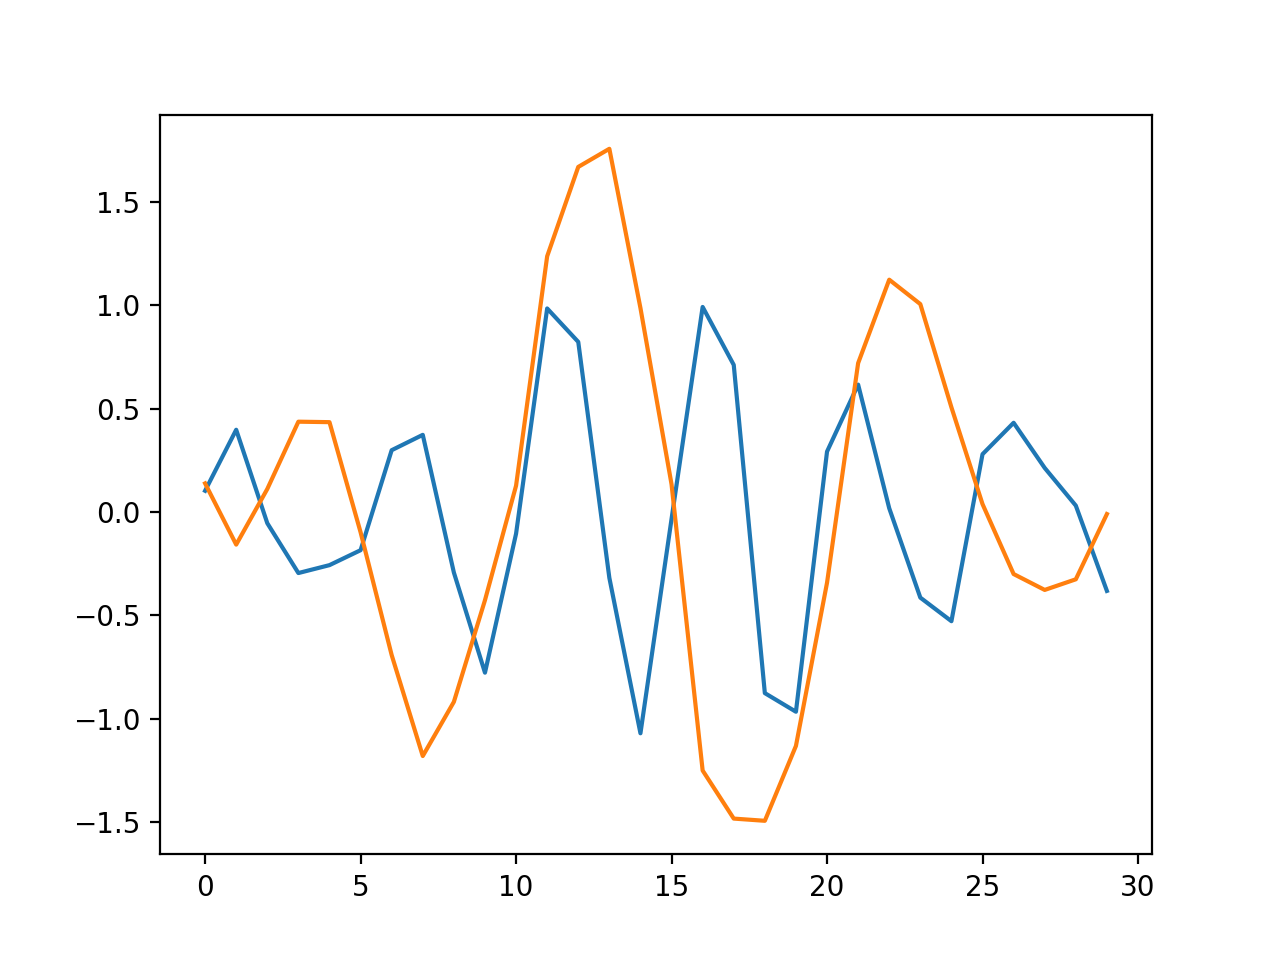

In [50]:
numer_filtru = 1
plt.figure()
plt.plot(w[0][:,0,numer_filtru])
plt.plot(w[0][:,1,numer_filtru])
plt.show()


Możemy też, potraktować je jako filtry FIR i wykreślić ich funkcję przenoszenia (transmitancję)

<IPython.core.display.Javascript object>


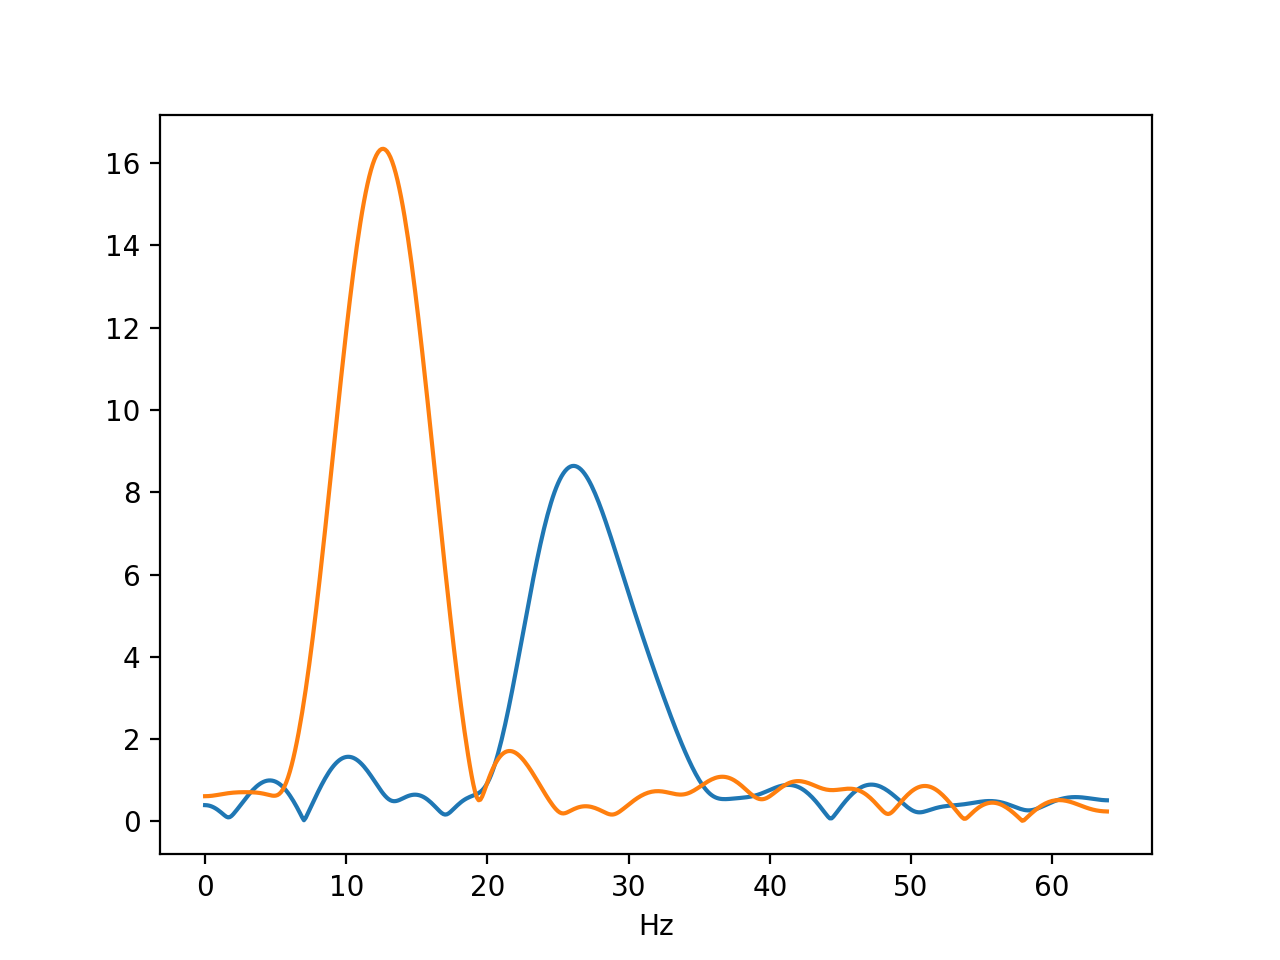

In [43]:
import scipy.signal as ss
b = w[0][:,0,0]
f, h0= ss.freqz(b, a=1, worN=512, whole=False,  fs=Fs)
b = w[0][:,1,0]
f, h1= ss.freqz(b, a=1, worN=512, whole=False,  fs=Fs)


plt.figure()
plt.plot(f, abs(h0))
plt.plot(f, abs(h1))
plt.xlabel('Hz')
plt.show()

In [9]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(seq_length, ch))
# a layer instance is callable on a tensor, and returns a tensor
output_1 = Conv1D(filters= 2, kernel_size = 30)(inputs)
output_2 = GlobalAveragePooling1D()(output_1)
prediction = Dense(2, activation='softmax')(output_2)
model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

model.fit(X_train, y_train, batch_size=16, epochs=10)
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 2)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 227, 2)            122       
_________________________________________________________________
global_average_pooling1d_2 ( (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
600/600 [==============================] - 2s 4ms/step - loss: 0.6926 - acc: 0.5200
Epoch 2/10
600/600 [==============================] - 0s 783us/step - loss: 0.6908 - acc: 0.5317
Epoch 3/10
600/600 [==============================] - 0s 439us/step - loss: 0.6